In [10]:
# Data Preperation
import pandas as pd

df = pd.read_csv('../data/news.tsv',sep='\t')
df.head()

,News ID,Category,Topic,Headline,News body,Title entity,Entity content
0,N10000,sports,soccer,Predicting Atlanta United's lineup against Col...,"Only FIVE internationals allowed, count em, FI...","{""Atlanta United's"": 'Atlanta United FC'}","{'Atlanta United FC': {'type': 'item', 'id': '..."
1,N10001,news,newspolitics,Mitch McConnell: DC statehood push is 'full bo...,WASHINGTON -- Senate Majority Leader Mitch McC...,"{'DC': 'Washington, D.C.'}","{'Washington, D.C.': {'type': 'item', 'id': 'Q..."
2,N10002,news,newsus,Home In North Highlands Damaged By Fire,NORTH HIGHLANDS (CBS13) Fire damaged a home ...,{},{}
3,N10003,news,newspolitics,Meghan McCain blames 'liberal media' and 'thir...,Meghan McCain is speaking out after a journali...,{},{}
4,N10004,news,newsworld,Today in History: Aug 1,"1714: George I becomes King Georg Ludwig, Elec...",{},{}


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Data Cleaniing and Preprocessing including Stopword Removal

import re
import string
import pandas as pd
from nltk.corpus import stopwords
import nltk

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):

    # This part handles cases where the input is not a string
    if not isinstance(text,str): 
        return ""
    
    # Remove HTML tags
    text =  re.sub(r"<.*?>"," ",text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+"," ",text)

    # Remove emojis
    text = re.sub(
        "[" 
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", 
        "", 
        text
    )

    #  Remove special symbols except letters, numbers, .,!?, and spaces
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", " ", text)

    #  Normalize punctuation (keep only .,!?)
    allowed = set(string.ascii_letters + string.digits + " .,!?")
    text = "".join(ch for ch in text if ch in allowed)

    #  Convert to lowercase
    text = text.lower()

    # Normalize whitespace
    text = " ".join(text.split())

     # Remove stopwords
    tokens = [
        word for word in text.split()
        if word not in STOPWORDS
    ]
    
    text = " ".join(tokens)

    return text


In [13]:
df["text"] = df["Headline"].fillna("") + " " + df["News body"].fillna("")
df = df.rename(columns={"Category": "label"}).dropna()

# cleaning BEFORE tokenization
df["clean_text"] = df["text"].apply(clean_text)

In [14]:
df.head()

,News ID,label,Topic,Headline,News body,Title entity,Entity content,text,clean_text
0,N10000,sports,soccer,Predicting Atlanta United's lineup against Col...,"Only FIVE internationals allowed, count em, FI...","{""Atlanta United's"": 'Atlanta United FC'}","{'Atlanta United FC': {'type': 'item', 'id': '...",Predicting Atlanta United's lineup against Col...,predicting atlanta united lineup columbus crew...
1,N10001,news,newspolitics,Mitch McConnell: DC statehood push is 'full bo...,WASHINGTON -- Senate Majority Leader Mitch McC...,"{'DC': 'Washington, D.C.'}","{'Washington, D.C.': {'type': 'item', 'id': 'Q...",Mitch McConnell: DC statehood push is 'full bo...,mitch mcconnell dc statehood push full bore so...
2,N10002,news,newsus,Home In North Highlands Damaged By Fire,NORTH HIGHLANDS (CBS13) Fire damaged a home ...,{},{},Home In North Highlands Damaged By Fire NORTH ...,home north highlands damaged fire north highla...
3,N10003,news,newspolitics,Meghan McCain blames 'liberal media' and 'thir...,Meghan McCain is speaking out after a journali...,{},{},Meghan McCain blames 'liberal media' and 'thir...,meghan mccain blames liberal media third wave ...
4,N10004,news,newsworld,Today in History: Aug 1,"1714: George I becomes King Georg Ludwig, Elec...",{},{},Today in History: Aug 1 1714: George I becomes...,today history aug 1 1714 george becomes king g...


In [15]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
import joblib
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])
joblib.dump(le, "../classification/label_encoder.pkl")

['../classification/label_encoder.pkl']

### EDA

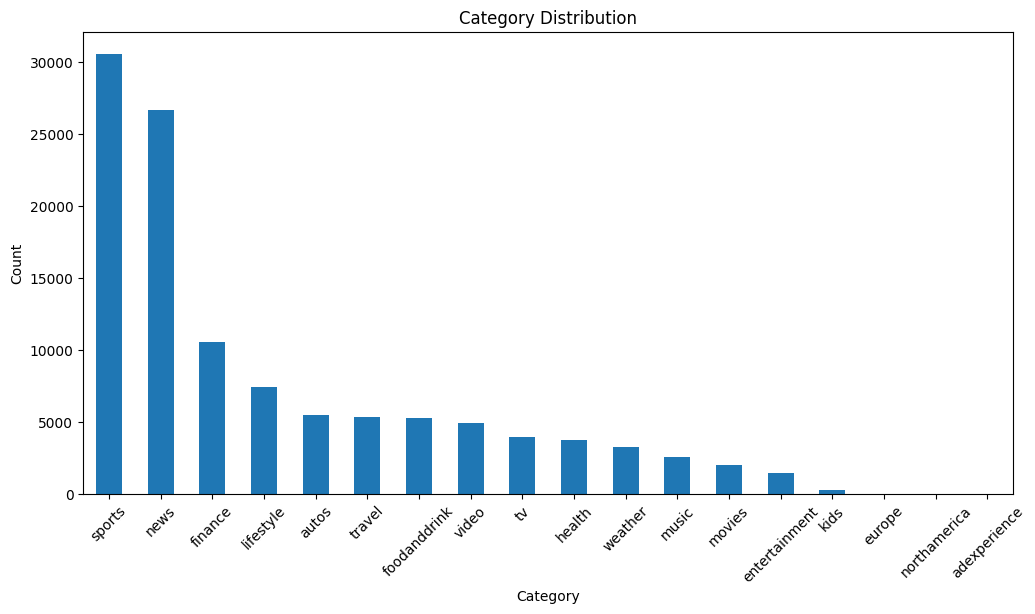

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
df["label"].value_counts().plot(kind="bar")
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


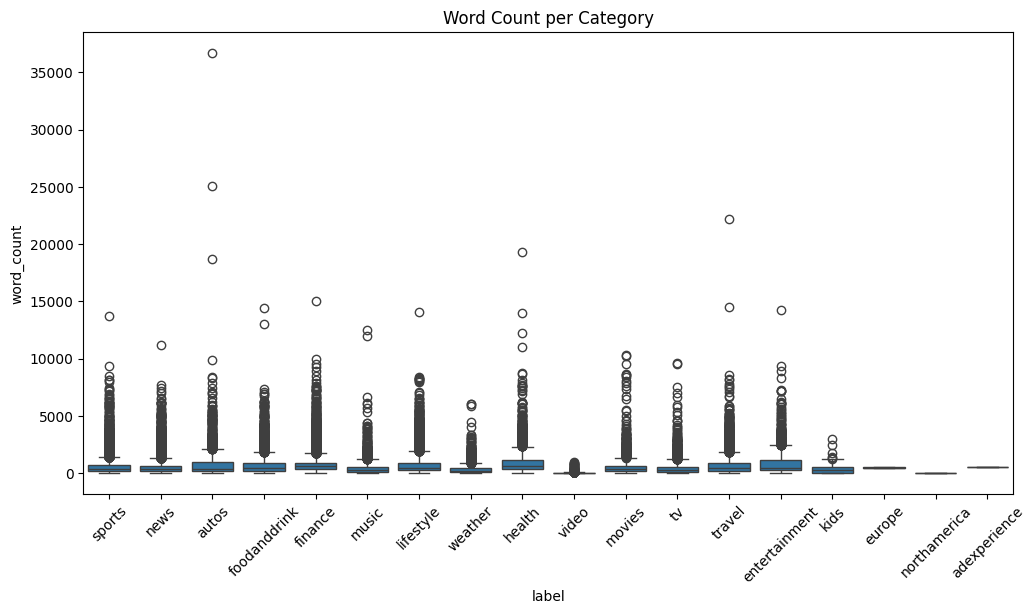

In [17]:
import seaborn as sns
def word_count(text):
    return len(text.split())

df["word_count"] = df["text"].apply(word_count)

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="label", y="word_count")
plt.xticks(rotation=45)
plt.title("Word Count per Category")
plt.show()


### ML Models

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib


In [19]:
df = df[["text", "label"]]
df["label_encoded"] = le.fit_transform(df["label"])
df

,text,label,label_encoded
0,Predicting Atlanta United's lineup against Col...,sports,13
1,Mitch McConnell: DC statehood push is 'full bo...,news,11
2,Home In North Highlands Damaged By Fire NORTH ...,news,11
3,Meghan McCain blames 'liberal media' and 'thir...,news,11
4,Today in History: Aug 1 1714: George I becomes...,news,11
...,...,...,...
113757,Hope who? Alyssa Naeher's penalty save sends U...,sports,13
113758,Chris Sale Explains What Specifically Has Gone...,sports,13
113759,Raptor fans jam streets to celebrate 1st NBA t...,sports,13
113760,Judge won't allow Flynn to fire his attorneys ...,news,11


In [20]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label_encoded"],
    test_size=0.2,
    random_state=42
)

In [21]:
# Four Models 

pipelines = {
    "LR_TFIDF": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
        ("clf", LogisticRegression(max_iter=5000))
    ]),

    "LR_BOW": Pipeline([
        ("bow", CountVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
        ("clf", LogisticRegression(max_iter=5000))
    ]),

    "SVM_TFIDF": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
        ("clf", LinearSVC())
    ]),

    "SVM_BOW": Pipeline([
        ("bow", CountVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
        ("clf", LinearSVC())
    ]),
}


In [22]:
# Evaluate Models
def evaluate_model(name, pipeline):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average="weighted", zero_division=0))
    print("Recall:", recall_score(y_test, preds, average="weighted", zero_division=0))
    print("F1 Score:", f1_score(y_test, preds, average="weighted", zero_division=0))
    print("\nClassification Report:\n", classification_report(y_test, preds, zero_division=0))

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Weighted F1": f1_score(y_test, preds, average="weighted")
    }

In [23]:
# Four Models Run


all_results = []

for name, pipe in pipelines.items():
    result = evaluate_model(name, pipe)
    all_results.append(result)

results_df = pd.DataFrame(all_results)
print("\n====== FINAL COMPARISON OF 4 MODELS ======")
print(results_df)



===== LR_TFIDF =====
Accuracy: 0.7810562420298139
Precision: 0.7810559453086995
Recall: 0.7810562420298139
F1 Score: 0.778427389726029

Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.82      0.84      1109
           2       0.72      0.37      0.49       310
           3       0.00      0.00      0.00         1
           4       0.83      0.79      0.81      2070
           5       0.85      0.81      0.83      1034
           6       0.83      0.74      0.78       744
           7       0.00      0.00      0.00        53
           8       0.66      0.65      0.66      1489
           9       0.73      0.65      0.69       415
          10       0.75      0.61      0.67       504
          11       0.70      0.81      0.75      5356
          13       0.94      0.95      0.95      6083
          14       0.69      0.56      0.62      1113
          15       0.67      0.60      0.63       837
          16       0.45     

c:\Users\Lenovo\miniconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== SVM_BOW =====
Accuracy: 0.7383580317488238
Precision: 0.7432515006221178
Recall: 0.7383580317488238
F1 Score: 0.7392217852092074

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.84      0.77      0.80      1109
           2       0.50      0.40      0.44       310
           3       0.00      0.00      0.00         1
           4       0.81      0.75      0.78      2070
           5       0.72      0.75      0.74      1034
           6       0.71      0.74      0.72       744
           7       0.06      0.08      0.07        53
           8       0.64      0.54      0.59      1489
           9       0.62      0.59      0.60       415
          10       0.62      0.60      0.61       504
          11       0.70      0.73      0.72      5356
          12       0.00      0.00      0.00         0
          13       0.92      0.94      0.93      6083
          14       0.63     

In [24]:
best_model_name = results_df.sort_values("Weighted F1", ascending=False).iloc[0]["Model"]
print("\nBest Model:", best_model_name)


Best Model: LR_TFIDF


In [25]:
best_model = pipelines[best_model_name]
best_model.fit(X_train, y_train)

joblib.dump(best_model, "../Classification/best_text_ML_model.pkl")
print("Model saved as best_text_ML_model.pkl")

Model saved as best_text_ML_model.pkl


# DL Model

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [27]:
df["clean_text"] = df["text"].apply(clean_text)

In [28]:
texts = df["clean_text"].values
labels = df["label"].values

In [29]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
    Input,
    Conv1D,
    GlobalMaxPooling1D,
    Concatenate,
    SpatialDropout1D,       # NEW: for better regularization in sequence models
    BatchNormalization      # NEW: for stabilizing activations
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # NEW: LR scheduler

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import pickle

In [30]:
df.head()
y = le.fit_transform(labels)
y= to_categorical(y)
num_classes = y.shape[1]

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42
)

In [32]:
# Tokenizer
MAX_WORDS = 50000
MAX_LEN = 150
EMBED_DIM = 300   # MUST MATCH Word2Vec or GloVe EMBEDDING DIMENSION

tokenizer = Tokenizer(num_words=MAX_WORDS,oov_token="<OOV>")
tokenizer.fit_on_texts(texts) # this assigns index to all words in the corpus means this have word and their index

# Convert texts to sequences and pad them
X_train_seq = tokenizer.texts_to_sequences(X_train) # converts each text to a sequence of integers based on the tokenizer's word index
X_test_seq  = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1) # +1 for padding token which is index 0



In [33]:
print("Vocab size:", vocab_size)
print("Num classes:", num_classes)

Vocab size: 50000
Num classes: 18


### Model Loads and Creating Embedding Matrix

In [34]:
# # load word2vec model
from gensim.models import KeyedVectors

model_path = r"D:/NLP_Word2Vec_Google/archive/GoogleNews-vectors-negative300.bin"

w2v_model = KeyedVectors.load_word2vec_format(model_path,binary=True)
print("Model Loaded Successfully!")

Model Loaded Successfully!


In [35]:
# Vector Embeddings of word2vec

embedding_matrix = np.zeros((vocab_size,EMBED_DIM))

for word,i in tokenizer.word_index.items():
    if i<MAX_WORDS:
        if word in w2v_model:
            embedding_matrix[i] = w2v_model[word]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBED_DIM,))

In [36]:
# Load GloVe Model and convert to word2vec format

from gensim.scripts.glove2word2vec import glove2word2vec

glove_input = "D:/NLP_Word2Vec_Google/glove.6B/glove.6B.300d.txt"
word2vec_output = "D:/NLP_Word2Vec_Google/glove.6B/glove.6B.300d.w2v.txt"
glove2word2vec(glove_input, word2vec_output)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4528\1336332027.py:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input, word2vec_output)


(400000, 300)

In [37]:
# load the Glove word2vec model
# the reason for converting the glove to word2vec is using golVe directly would be slow in parse time and use more ram

from gensim.models import KeyedVectors

gloVe_model = KeyedVectors.load_word2vec_format(
    r"D:/NLP_Word2Vec_Google/glove.6B/glove.6B.300d.w2v.txt",
    binary=False
)

In [38]:
# Vector Embeddings of GloVe
embedding_matrix_glove = np.zeros((vocab_size,EMBED_DIM))

for word,i in tokenizer.word_index.items():
    if i<MAX_WORDS:
        if word in gloVe_model:
            embedding_matrix_glove[i] = gloVe_model[word]
        else:
            embedding_matrix_glove[i] = np.random.normal(scale=0.6, size=(EMBED_DIM,))

In [39]:
embedding_matrix_glove.shape

(50000, 300)

In [40]:
# Common Callbacks for All DL Models

# NEW: ReduceLROnPlateau -> lower LR when val_loss plateaus (stabilizes training)
lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    verbose=1,
    min_lr=1e-6
)

early = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=1
)


####  MODEL 1: BiLSTM + Word2Vec

In [41]:
bilstm_w2v = Sequential([
    Embedding(
        vocab_size,
        EMBED_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False  # CHANGED: keep frozen for speed & stability; can set True later
    ),
    # NEW: SpatialDropout1D -> regularization at embedding level (drops whole word embeddings)
    SpatialDropout1D(0.2),
    # CHANGED: LSTM units 64 -> 128 for better capacity
    Bidirectional(
        LSTM(128, return_sequences=False, dropout=0.3)  # CHANGED: no recurrent_dropout -> faster GPU
    ),
    # NEW: BatchNormalization for stable training
    BatchNormalization(),
    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(num_classes, activation="softmax")
])

bilstm_w2v.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print("\n=== Training BiLSTM + Word2Vec ===")
history1 = bilstm_w2v.fit(
    X_train_pad, y_train,
    epochs=6,                    # CHANGED: 5 -> 6 (small increase, early stopping will prevent overfit)
    batch_size=128,              # same as you used; good tradeoff for GPU
    validation_data=(X_test_pad, y_test),
    callbacks=[early, lr_reducer],   # NEW: added lr_reducer
    verbose=1
)


c:\Users\Lenovo\miniconda3\envs\ml_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



=== Training BiLSTM + Word2Vec ===
Epoch 1/6
711/711 ━━━━━━━━━━━━━━━━━━━━ 209s 284ms/step - accuracy: 0.6250 - loss: 1.1993 - val_accuracy: 0.7107 - val_loss: 0.8780 - learning_rate: 0.0010
Epoch 2/6
711/711 ━━━━━━━━━━━━━━━━━━━━ 340s 478ms/step - accuracy: 0.6952 - loss: 0.9375 - val_accuracy: 0.7282 - val_loss: 0.8197 - learning_rate: 0.0010
Epoch 3/6
711/711 ━━━━━━━━━━━━━━━━━━━━ 410s 577ms/step - accuracy: 0.7190 - loss: 0.8567 - val_accuracy: 0.7327 - val_loss: 0.7908 - learning_rate: 0.0010
Epoch 4/6
711/711 ━━━━━━━━━━━━━━━━━━━━ 409s 575ms/step - accuracy: 0.7343 - loss: 0.8045 - val_accuracy: 0.7516 - val_loss: 0.7459 - learning_rate: 0.0010
Epoch 5/6
711/711 ━━━━━━━━━━━━━━━━━━━━ 424s 597ms/step - accuracy: 0.7447 - loss: 0.7623 - val_accuracy: 0.7612 - val_loss: 0.7186 - learning_rate: 0.0010
Epoch 6/6
711/711 ━━━━━━━━━━━━━━━━━━━━ 408s 573ms/step - accuracy: 0.7539 - loss: 0.7314 - val_accuracy: 0.7653 - val_loss: 0.7057 - learning_rate: 0.0010
Restoring model weights from the e

####  MODEL 2: TextCNN + Word2Vec

In [42]:
input_layer = Input(shape=(MAX_LEN,))
embed_layer = Embedding(
    vocab_size,
    EMBED_DIM,
    input_length=MAX_LEN,
    weights=[embedding_matrix],
    trainable=False          # CHANGED: keep frozen initially; can make True to fine-tune later
)(input_layer)

# NEW: SpatialDropout1D here also helps CNN generalization
x = SpatialDropout1D(0.2)(embed_layer)

conv3 = Conv1D(128, 3, activation="relu")(x)
conv4 = Conv1D(128, 4, activation="relu")(x)
conv5 = Conv1D(128, 5, activation="relu")(x)

pool3 = GlobalMaxPooling1D()(conv3)
pool4 = GlobalMaxPooling1D()(conv4)
pool5 = GlobalMaxPooling1D()(conv5)

merged = Concatenate()([pool3, pool4, pool5])

# NEW: BatchNormalization before dense
merged = BatchNormalization()(merged)

dense = Dense(256, activation="relu")(merged)
dropout = Dropout(0.5)(dense)  # CHANGED: a bit stronger dropout for CNN
output_layer = Dense(num_classes, activation="softmax")(dropout)

textcnn_w2v = Model(inputs=input_layer, outputs=output_layer)

textcnn_w2v.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print("\n=== Training TextCNN + Word2Vec ===")
history2 = textcnn_w2v.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=8,                   # CHANGED: 10 -> 8 (less overfitting, early stopping + LR reduction)
    batch_size=256,             # same as yours; CNN handles bigger batches efficiently
    callbacks=[early, lr_reducer],
    verbose=1
)


=== Training TextCNN + Word2Vec ===
Epoch 1/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.4262 - loss: 2.0193
Epoch 1: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
285/285 ━━━━━━━━━━━━━━━━━━━━ 196s 680ms/step - accuracy: 0.5296 - loss: 1.5931 - val_accuracy: 0.6687 - val_loss: 1.0220 - learning_rate: 0.0010
Epoch 2/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.6668 - loss: 1.0623
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
285/285 ━━━━━━━━━━━━━━━━━━━━ 190s 665ms/step - accuracy: 0.6764 - loss: 1.0247 - val_accuracy: 0.7105 - val_loss: 0.8986 - learning_rate: 5.0000e-04
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


#### MODEL 3: BiLSTM + GloVe

In [43]:
bilstm_glove = Sequential([
    Embedding(
        vocab_size,
        EMBED_DIM,
        weights=[embedding_matrix_glove],
        input_length=MAX_LEN,
        trainable=False
    ),
    SpatialDropout1D(0.2),        # NEW
    Bidirectional(
        LSTM(128, return_sequences=False, dropout=0.3)  # CHANGED units from 64 -> 128
    ),
    BatchNormalization(),         # NEW
    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(num_classes, activation="softmax")
])

bilstm_glove.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print("\n=== Training BiLSTM + GloVe ===")
history3 = bilstm_glove.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=8,               # CHANGED: 10 -> 8, with early stopping
    batch_size=128,
    callbacks=[early, lr_reducer],
    verbose=1
)



=== Training BiLSTM + GloVe ===
Epoch 1/8
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5692 - loss: 1.4270
Epoch 1: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
569/569 ━━━━━━━━━━━━━━━━━━━━ 323s 560ms/step - accuracy: 0.6449 - loss: 1.1370 - val_accuracy: 0.7281 - val_loss: 0.8264 - learning_rate: 0.0010
Epoch 2/8
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.7189 - loss: 0.8671
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
569/569 ━━━━━━━━━━━━━━━━━━━━ 324s 569ms/step - accuracy: 0.7247 - loss: 0.8449 - val_accuracy: 0.7557 - val_loss: 0.7321 - learning_rate: 5.0000e-04
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


#### MODEL 4: TextCNN + GloVe

In [44]:
input_layer_g = Input(shape=(MAX_LEN,))
embed_layer_g = Embedding(
    vocab_size,
    EMBED_DIM,
    weights=[embedding_matrix_glove],
    input_length=MAX_LEN,
    trainable=False
)(input_layer_g)

xg = SpatialDropout1D(0.2)(embed_layer_g)  # NEW

conv3_g = Conv1D(128, 3, activation="relu")(xg)
conv4_g = Conv1D(128, 4, activation="relu")(xg)
conv5_g = Conv1D(128, 5, activation="relu")(xg)

pool3_g = GlobalMaxPooling1D()(conv3_g)
pool4_g = GlobalMaxPooling1D()(conv4_g)
pool5_g = GlobalMaxPooling1D()(conv5_g)

merged_g = Concatenate()([pool3_g, pool4_g, pool5_g])

merged_g = BatchNormalization()(merged_g)   # NEW

dense_g = Dense(256, activation="relu")(merged_g)
drop_g = Dropout(0.5)(dense_g)
output_layer_g = Dense(num_classes, activation="softmax")(drop_g)

textcnn_glove = Model(inputs=input_layer_g, outputs=output_layer_g)

textcnn_glove.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print("\n=== Training TextCNN + GloVe ===")
history4 = textcnn_glove.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=256,
    callbacks=[early, lr_reducer],
    verbose=1
)



=== Training TextCNN + GloVe ===
Epoch 1/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.5890 - loss: 1.4151
Epoch 1: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
285/285 ━━━━━━━━━━━━━━━━━━━━ 199s 691ms/step - accuracy: 0.6658 - loss: 1.0950 - val_accuracy: 0.7535 - val_loss: 0.7613 - learning_rate: 0.0010
Epoch 2/8
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7439 - loss: 0.7911
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
285/285 ━━━━━━━━━━━━━━━━━━━━ 111s 389ms/step - accuracy: 0.7462 - loss: 0.7798 - val_accuracy: 0.7639 - val_loss: 0.7248 - learning_rate: 5.0000e-04
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


In [45]:
# save the tokenizer
pickle.dump(tokenizer, open("../Classification/tokenizer.pkl", "wb"))
print("Tokenizer saved to tokenizer.pkl")


Tokenizer saved to tokenizer.pkl


In [46]:
# EVALUATE & COMPARE DL MODELS (4)
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
models = {
    "BiLSTM_Word2Vec": bilstm_w2v,
    "TextCNN_Word2Vec": textcnn_w2v,
    "BiLSTM_GloVe": bilstm_glove,
    "TextCNN_GloVe": textcnn_glove
}

y_test_labels = np.argmax(y_test, axis=1)
dl_results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    y_pred = model.predict(X_test_pad, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test_labels, y_pred_labels)
    
    report = classification_report(
        y_test_labels,
        y_pred_labels,
        output_dict=True,
        zero_division=0
    )

    dl_results[name] = {
        "accuracy": acc,
        "f1_macro": report["macro avg"]["f1-score"],
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"]
    }

    print(classification_report(
        y_test_labels,
        y_pred_labels,
        zero_division=0
    ))
    print("=" * 80)

df_results = pd.DataFrame(dl_results).T
df_results = df_results.sort_values(by="accuracy", ascending=False)

print("\nDL Model comparison (4 models):\n")
print(df_results)

best_dl_model_name = df_results.index[0]
print("\nBest DL model based on accuracy:", best_dl_model_name)
print(df_results.loc[best_dl_model_name])


Evaluating BiLSTM_Word2Vec...
              precision    recall  f1-score   support

           1       0.82      0.84      0.83      1109
           2       0.46      0.35      0.40       310
           3       0.00      0.00      0.00         1
           4       0.82      0.77      0.80      2070
           5       0.83      0.81      0.82      1034
           6       0.72      0.78      0.75       744
           7       0.00      0.00      0.00        53
           8       0.64      0.59      0.62      1489
           9       0.64      0.59      0.61       415
          10       0.67      0.62      0.64       504
          11       0.72      0.74      0.73      5356
          13       0.94      0.95      0.95      6083
          14       0.68      0.51      0.58      1113
          15       0.55      0.62      0.58       837
          16       0.49      0.52      0.50       969
          17       0.58      0.86      0.69       654

    accuracy                           0.77     2

In [47]:
# Save best DL model to .h5
best_dl_model = models[best_dl_model_name]
dl_save_path = f"../Classification/{best_dl_model_name}.h5"
best_dl_model.save(dl_save_path)
print(f"\nSaved best DL model as: {dl_save_path}")


Saved best DL model as: ../Classification/BiLSTM_Word2Vec.h5


In [48]:
ml_results = results_df.copy()  
ml_results["Type"] = "ML"

dl_results = df_results.copy()
dl_results = dl_results.rename(columns={
    "accuracy": "Accuracy",
    "f1_macro": "F1",
    "precision_macro": "Precision",
    "recall_macro": "Recall"
})
dl_results["Model"] = dl_results.index
dl_results["Type"] = "DL"
dl_results = dl_results.reset_index(drop=True)

final_results = pd.concat([ml_results, dl_results], ignore_index=True)

print("\n============ 🔥 FINAL COMPARISON: ML vs DL (8 MODELS) 🔥 ============\n")
print(final_results)

# ==========================================================
# IDENTIFY BEST MODELS
# ==========================================================

best_overall = final_results.loc[final_results["Accuracy"].idxmax()]
best_ml = ml_results.loc[ml_results["Accuracy"].idxmax()]
best_dl = dl_results.loc[dl_results["Accuracy"].idxmax()]

print("\n================== 🏆 BEST MODELS ==================")
print("\nBest ML Model:")
print(best_ml)

print("\nBest DL Model:")
print(best_dl)

print("\n🏆 BEST OVERALL MODEL:")
print(best_overall)


============ 🔥 FINAL COMPARISON: ML vs DL (8 MODELS) 🔥 ============

              Model  Accuracy  Weighted F1 Type        F1  Precision    Recall
0          LR_TFIDF  0.781056     0.778427   ML       NaN        NaN       NaN
1            LR_BOW  0.727101     0.727977   ML       NaN        NaN       NaN
2         SVM_TFIDF  0.775296     0.772787   ML       NaN        NaN       NaN
3           SVM_BOW  0.738358     0.739222   ML       NaN        NaN       NaN
4   BiLSTM_Word2Vec  0.765314          NaN   DL  0.594127   0.598757  0.596369
5     TextCNN_GloVe  0.748384          NaN   DL  0.563367   0.597666  0.558579
6      BiLSTM_GloVe  0.727760          NaN   DL  0.522318   0.592233  0.523954
7  TextCNN_Word2Vec  0.665582          NaN   DL  0.398899   0.527986  0.378605

================== 🏆 BEST MODELS ==================

Best ML Model:
Model          LR_TFIDF
Accuracy       0.781056
Weighted F1    0.778427
Type                 ML
Name: 0, dtype: object

Best DL Model:
Accuracy       

#### Transformers

In [49]:
import pandas as pd
df = pd.read_csv('../data/news.tsv', sep='\t')
df.head()

,News ID,Category,Topic,Headline,News body,Title entity,Entity content
0,N10000,sports,soccer,Predicting Atlanta United's lineup against Col...,"Only FIVE internationals allowed, count em, FI...","{""Atlanta United's"": 'Atlanta United FC'}","{'Atlanta United FC': {'type': 'item', 'id': '..."
1,N10001,news,newspolitics,Mitch McConnell: DC statehood push is 'full bo...,WASHINGTON -- Senate Majority Leader Mitch McC...,"{'DC': 'Washington, D.C.'}","{'Washington, D.C.': {'type': 'item', 'id': 'Q..."
2,N10002,news,newsus,Home In North Highlands Damaged By Fire,NORTH HIGHLANDS (CBS13) Fire damaged a home ...,{},{}
3,N10003,news,newspolitics,Meghan McCain blames 'liberal media' and 'thir...,Meghan McCain is speaking out after a journali...,{},{}
4,N10004,news,newsworld,Today in History: Aug 1,"1714: George I becomes King Georg Ludwig, Elec...",{},{}


In [50]:
import pandas as pd

# Load Transformer metrics
trans_csv = "model_comparisons.csv"
transformer_df = pd.read_csv(trans_csv)

print("\n=== TRANSFORMER RESULTS ===")
print(transformer_df)



=== TRANSFORMER RESULTS ===
   eval_loss  eval_accuracy   eval_f1  eval_precision  eval_recall  \
0    0.64046       0.796227  0.795465        0.796033     0.796227   
1    0.63195       0.795040  0.793676        0.795033     0.795040   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  \
0      265.8418                   85.543                 10.694    2.0   
1       77.2938                  294.215                 18.397    2.0   

                model_name  
0        BERT-base-uncased  
1  DistilBERT-base-uncased  


In [51]:
# Prepare ML results for comparison

ml_results = results_df.copy()
ml_results = ml_results.rename(columns={
    "Model": "Model",
    "Accuracy": "Accuracy",
    "Weighted F1": "F1"
})
ml_results["Precision"] = None
ml_results["Recall"] = None
ml_results["Type"] = "ML"

# Prepare DL results for comparison

dl_std = df_results.copy()

dl_std = dl_std.rename(columns={
    "accuracy": "Accuracy",
    "f1_macro": "F1",
    "precision_macro": "Precision",
    "recall_macro": "Recall"
})

dl_std["Model"] = dl_std.index
dl_std["Type"] = "DL"
dl_std = dl_std.reset_index(drop=True)

# Prepare Transformer results for comparison

tfm_std = transformer_df.rename(columns={
    "model_name": "Model",
    "eval_accuracy": "Accuracy",
    "eval_f1": "F1",
    "eval_precision": "Precision",
    "eval_recall": "Recall"
})

tfm_std["Type"] = "TRANSFORMER"
tfm_std = tfm_std[["Model","Type","Accuracy","F1","Precision","Recall"]]



In [52]:
# Merge all results
final_comparison_df = pd.concat(
    [
        ml_results[["Model","Type","Accuracy","F1","Precision","Recall"]],
        dl_std[["Model","Type","Accuracy","F1","Precision","Recall"]],
        tfm_std
    ],
    ignore_index=True
)

print("\n==================== 🔥 FINAL MODEL COMPARISON 🔥 ====================\n")
print(final_comparison_df.sort_values("Accuracy", ascending=False))



==================== 🔥 FINAL MODEL COMPARISON 🔥 ====================

                     Model         Type  Accuracy        F1  Precision  \
8        BERT-base-uncased  TRANSFORMER  0.796227  0.795465   0.796033   
9  DistilBERT-base-uncased  TRANSFORMER  0.795040  0.793676   0.795033   
0                 LR_TFIDF           ML  0.781056  0.778427        NaN   
2                SVM_TFIDF           ML  0.775296  0.772787        NaN   
4          BiLSTM_Word2Vec           DL  0.765314  0.594127   0.598757   
5            TextCNN_GloVe           DL  0.748384  0.563367   0.597666   
3                  SVM_BOW           ML  0.738358  0.739222        NaN   
6             BiLSTM_GloVe           DL  0.727760  0.522318   0.592233   
1                   LR_BOW           ML  0.727101  0.727977        NaN   
7         TextCNN_Word2Vec           DL  0.665582  0.398899   0.527986   

     Recall  
8  0.796227  
9  0.795040  
0       NaN  
2       NaN  
4  0.596369  
5  0.558579  
3       NaN  
6 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4528\3542548838.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_comparison_df = pd.concat(


In [53]:
best_overall = final_comparison_df.loc[
    final_comparison_df["Accuracy"].idxmax()
]

print("\n==================== 🏆 FINAL SELECTED MODEL 🏆 ====================")
print("Model Name :", best_overall["Model"])
print("Model Type :", best_overall["Type"])
print("Accuracy   :", round(best_overall["Accuracy"],4))
print("F1 Score   :", round(best_overall["F1"],4))
print("Precision  :", round(best_overall["Precision"],4)
      if best_overall["Precision"]!=None else "N/A")
print("Recall     :", round(best_overall["Recall"],4)
      if best_overall["Recall"]!=None else "N/A")



==================== 🏆 FINAL SELECTED MODEL 🏆 ====================
Model Name : BERT-base-uncased
Model Type : TRANSFORMER
Accuracy   : 0.7962
F1 Score   : 0.7955
Precision  : 0.796
Recall     : 0.7962
